In [ ]:
from google.colab import drive
drive.mount('MyDrive')
%cd MyDrive/MyDrive

Mounted at MyDrive
/content/MyDrive/MyDrive


In [ ]:
PATH = 'Data/DG_1D_Data'
import os
NUM_FILES = len(os.listdir(PATH))

In [ ]:
print(f'The number of examples is {NUM_FILES}')

The number of examples is 10000


In [ ]:
import numpy as np
from scipy.special import gamma
from scipy.sparse import csr_matrix, identity, find
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
def sub2ind(sz, row, col):
    n_rows = sz[0]
    return [n_rows * c + r for r, c in zip(row, col)]
def JacobiP(x, alpha, beta, N):
    '''
    Calculates the value of jacobi polynomial of type alpha, beta at points x
    for  order N.
    x: Numpy array
    '''
    xp = x.reshape(1, -1)
    n = xp.shape[1]
    PL = np.zeros((N+ 1, n))

    gamma0 = np.power(2, alpha + beta + 1)/(alpha + beta + 1) *gamma(alpha + 1) * gamma(beta + 1)/gamma(alpha + beta + 1)
    PL[0, :] = 1.0/np.sqrt(gamma0)
    if N == 0:
        return PL.T

    gamma1 = (alpha + 1)*(beta + 1)/(alpha + beta +3)* gamma0

    PL[1, :] = ((alpha + beta +  2) * xp/2 + (alpha - beta)/2)/np.sqrt(gamma1)

    if N == 1:
        return PL[N, :]

    aold = 2/(2 + alpha + beta) * np.sqrt((alpha + 1) *(beta + 1)/(alpha + beta + 3))
    for i in range(N - 1):
        h1 = 2*(i + 1) + alpha + beta
        anew = 2/(h1 + 2) * np.sqrt((i + 2) * (i+2 + alpha + beta) * (i + 2 + alpha) *(i + 2 + beta)/(h1 + 1)/(h1 + 3))
        bnew = -(alpha ** 2 - beta**2)/h1/(h1 + 2)
        PL[i + 2, : ] = 1/(anew) *(-aold * PL[i, :] + (xp - bnew) *PL[i + 1, :])
        aold = anew
    return PL[N, :]

def JacobiGQ(alpha, beta, N):
    '''
    Computes the Nth order Guass Quadrature points(x) and the
    associated weights(w), associated with the Jacobi polynomial of type (alpha, beta)
    '''
    if N == 0:
        zer = (alpha - beta)/(alpha + beta + 2)
        wt = 2
        return np.array([zer]), np.array([wt])


    J = np.zeros((N + 1, N + 1))
    brr = np.array(range(1, N + 1))
    h1 = 2 * np.array(range(N  + 1)) + alpha + beta
    J = np.diag(-1/2 * (alpha ** 2 - beta ** 2)/(h1 + 2)/h1) + np.diag(
        2/(h1[:N]  + 2) * np.sqrt(brr * (brr  + alpha + beta )*(brr + alpha) * (brr + beta)/(h1[:N] + 1)/(h1[:N] + 3)), 1
        )
    eps = 1e-5
    if alpha + beta < 10 * eps:

        J[0, 0] = 0
    J = J + J.T

    D, V = np.linalg.eig(J)
    x = D
    w = np.power(V[0, :].T, 2) * (2**(alpha + beta + 1))/(alpha + beta + 1) * gamma(alpha  + 1) * gamma(beta + 1)/gamma(alpha + beta + 1)
    return x, w


def JacobiGL(alpha, beta, N):
    '''
    Computes the Nth order Gauss Lobato quadrature points(x), associated
    with the Jacobi polynomial of type (alpha, beta)
    '''
    x = np.zeros((N + 1, 1))
    if N == 1:
        return np.array([-1, 1])
    xint, _ = JacobiGQ(alpha + 1, beta + 1, N - 2)
    ind = xint.argsort(axis = None)
    xint = xint[ind]
    x = np.concatenate(([-1], xint, [1]))

    return x

def MeshGen1D(xmin, xmax, K):
    '''
    Function to generate mesh with K elements which are equidistant
    '''
    Nv = K + 1
    VX = np.array(range(Nv), dtype = np.float128)
    for i in range(Nv):
        VX[i] = (xmax - xmin) *(i)/(Nv - 1) + xmin
    EToV = np.zeros((K, 2))
    for k in range(K):
        EToV[k, 0] = k
        EToV[k, 1] = k + 1
    return Nv, VX, K, EToV



def Vandermonde1D(N, r):
    '''
    Function to calculate the vandermonde martrix
    V_{ij} = phi_j(r_i)
    '''
    n = max(r.shape)
    V1D = np.zeros((n, N + 1))
    for j in range(N + 1):
        V1D[:, j] = JacobiP(r, 0, 0,j ).reshape((n, ))
    return V1D

def GradJacobiP(r, alpha, beta, N):
    '''
    Function to calculate the derivative of the jacobi polynomial
    of type (alpha, beta) at points r for order N and returns
    '''
    r = r.reshape(-1, 1)
    dP = np.zeros(r.shape)
    if N == 0:
        dP[:, :] = 0.0
    else:
        dP = np.sqrt(N*(N + alpha + beta + 1)) * JacobiP(r, alpha + 1, beta + 1, N  - 1)

    return dP

def GradVandermonde1D(N, r):
    '''
    Initialize the gradient of the modal basis (i) at (r) at order N
    '''
    n = max(r.shape)
    DVr = np.zeros((n, N+ 1))
    for i in range(N + 1):
        DVr[:, i ] = GradJacobiP(r, 0, 0, i).reshape((n,))
    return DVr


def Dmatrix1D(N, r, V):
    '''
    Function to calculate the differentiation matrix on the interval,
    evaluated at (r) at order N
    '''
    Vr = GradVandermonde1D(N, r)
    Dr = Vr @ np.linalg.pinv(V)
    return Dr


def Lift1D():
    '''
    Compute surface integral term in dg-formulation
    '''
    global Np, Nfaces, Nfp
    global V
    Emat = np.zeros((Np, Nfaces * Nfp))

    Emat[0, 0] = 1.0
    Emat[Np -1, 1] = 1.0

    Lift = V@(V.T @ Emat)
    return Lift





def GeometricFactors1D(x, Dr):
    '''
    Computes the metric elements for the local mappings
    of the 1D elements
    '''
    xr = Dr@x
    J = xr
    rx = 1/J
    return rx, J




def Normals1D():
    global Nfp, Nfaces, K
    nx = np.zeros((Nfp*Nfaces, K))
    nx[0, :] = -1.0
    nx[1, :] = 1.0
    return nx






def Connect1D(EToV):
    '''
    Build Global connectivity arrays for 1D grid based on standard
    EToV input array from grid generator
    '''
    global Nfaces
    K = EToV.shape[0]
    TotalFaces = Nfaces*K
    Nv = K + 1
    vn = np.array([0, 1])

    sk = 1
    rows = []
    cols = []
    sk = 0
    for k in range(K):
        for face in range(Nfaces):
            rows.append(sk)
            cols.append(EToV[k, vn[face]])
            sk += 1
    data = [1]*len(cols)
    SpFToV = csr_matrix((data, (rows, cols)), shape = (TotalFaces, Nv))

    SpFToF = SpFToV@(SpFToV.T) - identity(TotalFaces)

    faces1 , faces2, _ = find(SpFToF == 1)
    element1 = faces1//Nfaces
    face1    = faces1%Nfaces
    element2 = faces2//Nfaces
    face2    = faces2 % Nfaces
    ind = sub2ind([K, Nfaces], element1, face1)
    ind = np.array(ind)
    EToE = np.array(range(K)).reshape(-1, 1)@np.ones((1, Nfaces))
    EToF = np.ones((K, 1))@np.array(range(Nfaces)).reshape(1, -1)
    EToE[ind%K, ind//K] = element2
    EToF[ind%K, ind//K] = face2
    return EToE, EToF


def BuildMaps1D():
    global K, Np, Nfaces, Nfp, NODETOL
    global EToE, EToV, EToF
    global Fmask
    global x


    nodeids = np.array(range(K*Np)).reshape(Np, K, order = 'F')
    vmapM = np.zeros((Nfp, Nfaces, K))
    vmapP = np.zeros((Nfp, Nfaces, K))
    for k1 in range(K):
        for f1 in range(Nfaces):
            vmapM[:, f1, k1] = nodeids[Fmask[f1], k1]



    for k1 in range(K):
        for f1 in range(Nfaces):
            k2 = int(EToE[k1, f1])
            f2 = int(EToF[k1, f1])

            vidM = vmapM[:, f1, k1]
            vidP = vmapM[:, f2, k2]
            vidM = vidM.astype(np.uint16)
            vidP = vidP.astype(np.uint16)
            vidM_ = np.unravel_index(vidP, x.shape, 'F')
            vidP_ = np.unravel_index(vidP , x.shape, 'F')
            x1 = x[vidM_]
            x2 = x[vidP_]
            D = (x1 -x2)**2
            if D < NODETOL:
                vmapP[:, f1, k1] = vidP

    vmapP = vmapP.ravel('F')
    vmapM = vmapM.ravel('F')
    mapB = np.where(vmapP == vmapM)
    global vmapB, mapI, map0, vmapI, vmap0
    vmapB = vmapM[mapB]
    mapI = 0
    map0 = K*Nfaces - 1
    vmapI = 0
    vmap0 = K*Np - 1

    return vmapM, vmapP, vmapB, mapB

def Globals1D():
    global N, Nfp, Np, K
    global r , x , VX
    global Dr, LIFT
    global nx, Fx, Fscale
    global vmapM, vmapP, vmapB, mapB, Fmask
    global vmapI, vmap0, mapI, map0
    global rx, J
    global rk4a, rk4b, rk4c
    global Nfaces, EToE, EToF
    global V, invV
    global NODETOL

    rk4a = np.array([
        0.0,
        -567301805773.0/1357537059087.0,
        -2404267990393.0/2016746695238.0,
        -3550918686646.0/2091501179385.0,
        -1275806237668.0/842570457699.0
    ])
    rk4b = np.array([
        1432997174477.0/9575080441755.0,
        5161836677717.0/13612068292357.0,
        1720146321549.0/2090206949498.0,
        3134564353537.0/4481467310338.0,
        2277821191437.0/14882151754819.0
    ])
    rk4c = np.array([
         0.0,
         1432997174477.0/9575080441755.0,
         2526269341429.0/6820363962896.0,
         2006345519317.0/3224310063776.0,
         2802321613138.0/2924317926251.0
    ])
    NODETOL = 1e-10


def StartUp1D():
    Globals1D()
    global N, Nfp, Np, K
    global r , x , VX
    global Dr, LIFT
    global nx, Fx, Fscale
    global vmapM, vmapP, vmapB, mapB, Fmask
    global vmapI, vmap0, mapI, map0
    global rx, J
    global rk4a, rk4b, rk4c
    global Nfaces, EToE, EToF, EToV
    global V, invV
    global NODETOL
    Np = N + 1
    Nfp = 1
    Nfaces = 2
    r = JacobiGL(0, 0, N)
    V = Vandermonde1D(N, r)
    invV = np.linalg.pinv(V)
    Dr = Dmatrix1D(N, r, V)
    LIFT = Lift1D()
    va = EToV[:, 0].reshape(1, -1)
    va = va.ravel()
    vb  = EToV[:, 1].reshape(1, -1)
    vb = vb.ravel()

    fmask1 = np.where(abs(1 + r)< NODETOL)
    fmask2 = np.where(abs(1  - r) < NODETOL)
    Fmask = [fmask1[0][0], fmask2[0][0]]

    r = r.reshape(-1, 1)
    x = np.ones((N + 1, 1)) @( VX[va.astype(np.uint8)].reshape(1, -1)) + 0.5 * ( 1 + r) @ ((VX[vb.astype(np.uint8)] - VX[va.astype(np.uint8)]).reshape(1, - 1))

    rx, J = GeometricFactors1D(x, Dr)

    EToE, EToF = Connect1D(EToV)
    Fx = x[np.ravel(np.array(Fmask)), :]

    nx = Normals1D()

    Fscale = 1/J[np.array(Fmask), :]
    vmapM, vmapP, vmapB, mapB = BuildMaps1D()



def AdvecRHS1D(u, time, a):
    '''
    Evaluate the RHS flux in 1D Advection
    '''
    global Nfp, Nfaces, K
    global vmapP, vmapM, vmapB, mapB
    global mapI, vmapI, map0, vmap0
    global Dr
    global nx
    global bc




    alpha = 0.5
    vmapM = vmapM.astype(np.int16)
    vmapP = vmapP.astype(np.int16)
    # mapI = mapI.astype(np.int16)
    # map0 = map0.astype(np.int16)
    vmapM_ = np.unravel_index(vmapM, u.shape, 'F')
    vmapP_ = np.unravel_index(vmapP, u.shape, 'F')

    du = ((u[vmapM_]  - u[vmapP_]).reshape(nx.shape, order = 'F')) * (a * nx - (1 - alpha)* np.abs(a * nx))/2


    uin = bc(-a * time)
    mapI_ = np.unravel_index(mapI, du.shape, 'F')
    map0_ = np.unravel_index(map0, du.shape, 'F')
    vmapI_ = np.unravel_index(vmapI, du.shape, 'F')
    du[mapI_] = (u[vmapI_] - uin)*(a* nx[mapI_] - (a - alpha) * np.abs(a * nx[mapI_]))/2

    map0_  = np.unravel_index(map0, du.shape, 'F')
    du[map0_] = 0

    rhsu = - a* rx * (Dr@u) + LIFT@(Fscale * du)
    # print(f"Fmask : {Fmask}")
    # print(f"Fscale : {Fscale}")
    # print(f'J : {J}')
    # print(f"r : {r}")
    return rhsu



def Advec1D(u, a, finalTime):
    time = 0
    global Nfp, Nfaces, K
    global vmapP, vmapM, vmapB, mapB
    global mapI, vmapI, map0, vmap0
    global Dr
    global nx
    global bc
    global rk4c
    global N


    resu = np.zeros((Np, K))
    xmin = min(abs(x[0, :] - x[1, :]))

    CFL  = 0.75
    dt = (CFL/a)*xmin
    dt = 0.5 * dt
    Nsteps = np.ceil(finalTime/dt)
    dt = finalTime/Nsteps
    Nsteps = int(Nsteps)
    for tstep  in range(Nsteps):
        for INTRK in range(5):
            timelocal = time + rk4c[INTRK]*dt


            rhsu = AdvecRHS1D(u, timelocal, a)
            resu = rk4a[INTRK] * resu + dt * rhsu

            u = u + rk4b[INTRK] * resu

        time = time + dt

    return u

def sin2npi(x):
  return np.sin(2 * np . pi * x)
def AdvecDriver1D():
    Globals1D()
    global N, Nfp, Np, K
    global r , x , VX
    global Dr, LIFT
    global nx, Fx, Fscale
    global vmapM, vmapP, vmapB, mapB, Fmask
    global vmapI, vmap0, mapI, map0
    global rx, J
    global rk4a, rk4b, rk4c
    global Nfaces, EToE, EToF, EToV
    global V, invV
    global NODETOL
    global bc
    bc = np.sin
    N = 8
    Nv, VX, K, EToV = MeshGen1D(0.0, 2.0 * np.pi, 10)
    StartUp1D()
    # print(f"V : {V}")
    u = np.sin(x)
    finalTime = 0.8
    u = Advec1D(u, 2*np.pi, finalTime)

    from matplotlib import pyplot as plt
    plt.plot(x.ravel('F'), u.ravel('F'), 'x')
    plt.plot(x.ravel('F'), np.sin(  x).ravel('F'))
    plt.plot(x.ravel('F'), np.sin( x- 2 * np.pi * finalTime ).ravel('F'))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['FinalTime ', 'Time 0', 'Expect'])
    plt.show()



In [ ]:
N = 8
Nv, VX, K, EToV = MeshGen1D(0.0, 1, 100)
StartUp1D()
print(f'x.shape : {x.shape}')

x.shape : (9, 100)


In [ ]:
def visualiseExample(index):
  file = np.load(PATH + '/' + str(index) + '.npy', allow_pickle = True)
  data = file[()]
  u = data['u']
  labels = data['labels']
  labels = np.concatenate([[0], labels])
  print(f'labels : {labels}')
  advectionSpeed = data['advectionSpeed']
  finalTime = data['finalTime']
  print(f'Advection Speed : {advectionSpeed}')
  print(f'Final Time : {finalTime}')
  h = 1/100
  labels = labels * h
  labels = labels + advectionSpeed*finalTime
  labels = np.divmod(labels, 1)[1]
  print(f'Discont positions :{labels}')
  print(f'Element indices : {np.floor(labels/h)}')
  plt.scatter(x.ravel('F'), u.ravel('F'), s = 1)
  for xc in labels:
    plt.axvline(x=xc)



labels : [ 0  3 35 45 52 88 91 94]
Advection Speed : 0.5784825012181619
Final Time : 0.12651277363589963
Discont positions :[0.073 0.103 0.423 0.523 0.593 0.953 0.983 0.013]
Element indices : [7.000 10.000 42.000 52.000 59.000 95.000 98.000 1.000]


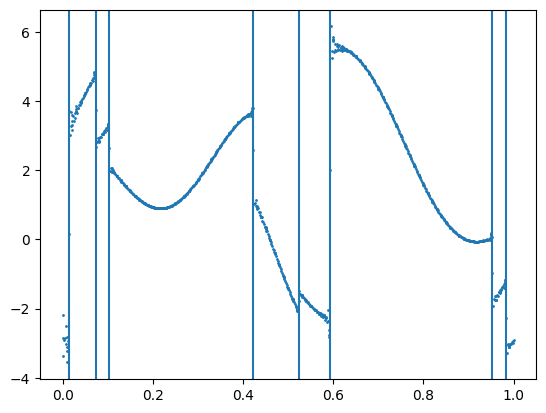

In [ ]:
visualiseExample(10)

labels : [0]
Advection Speed : 0.8569936200634891
Final Time : 0.20644981627323652
Discont positions :[0.177]
Element indices : [17.000]


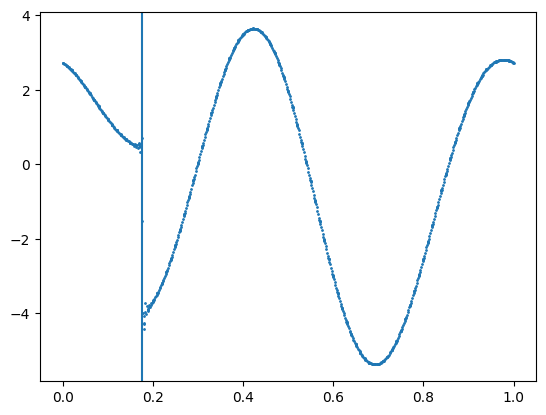

In [ ]:
visualiseExample(549)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
torch.set_default_tensor_type(torch.DoubleTensor)
class DiscontDataset(Dataset):

  def __init__(self, start,end):
    self.path = PATH
    self.start = start
    self.end = end

  def __len__(self):
    return self.end - self.start  +1

  def __getitem__(self, index):
    index = index + self.start + 1
    file = np.load(PATH + '/' + str(index) + '.npy', allow_pickle = True)
    data = file[()]
    u = data['u']
    u = (u - u.min())/(u.max() - u.min()) # Min-Max Normalization
    labels = data['labels']
    labels = np.concatenate([[0], labels])
    advectionSpeed = data['advectionSpeed']
    finalTime = data['finalTime']
    h = 1/100
    labels = labels * h
    labels = labels + advectionSpeed*finalTime
    labels = np.divmod(labels, 1)[1]
    y = np.zeros((100, ))
    labels = np.floor(labels/h)
    labels = list(map(int, labels))
    for label in labels:
      y[label] = 1
    return torch.tensor(u.astype(np.float16)), torch.tensor(y)

In [ ]:
dd = DiscontDataset(0, int(0.95 *NUM_FILES) - 1)
x, y = dd[0]
print(f'x.shape : {x.shape}, y.shape : {y.shape}')

x.shape : torch.Size([9, 100]), y.shape : torch.Size([100])


In [ ]:
x.dtype, y.dtype

(torch.float16, torch.float64)

In [ ]:
train_dataset, valid_dataset = DiscontDataset(1, 9500), DiscontDataset(9501, 9999)


In [ ]:
train_loader, valid_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True), DataLoader(valid_dataset, batch_size = 16)

In [ ]:
len(train_loader), len(valid_loader)

(594, 32)

In [ ]:
class DiscontModel(nn.Module):

  def __init__(self):
    super(DiscontModel, self).__init__()
    self.layer1 = nn.Conv1d(in_channels = 9, out_channels = 24, kernel_size = 2)
    self.layer2 = nn.Conv1d(in_channels = 24,out_channels = 24, kernel_size = 2)
    self.layer3 = nn.Conv1d(in_channels = 24, out_channels = 24, kernel_size = 2)
    self.layer4 = nn.Conv1d(in_channels = 24, out_channels = 24, kernel_size =2)
    self.flatter = nn.Flatten()
    self.layer5 = nn.Linear(in_features = 96*24, out_features = 100)

  def forward(self, x):
    out1 = self.layer1(x)
    out1 = nn.ReLU()(out1)
    # print(f'out1.shape : {out1.shape}')
    out2 = self.layer2(out1)
    out2 = nn.ReLU()(out2)
    # print(f'out.shape : {out2.shape}')
    out3 = self.layer3(out2)
    out3 = nn.ReLU()(out3)
    # print(f'out3.shape : {out3.shape}')
    out4  = self.layer4(out3)
    out4 = nn.ReLU()(out4)
    flat = self.flatter(out4)
    # print(f'out.shape : {flat.shape}')
    out = self.layer5(flat)

    out = nn.Sigmoid()(out)
    return out


In [ ]:
from tqdm.notebook import tqdm
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.type(torch.DoubleTensor)
        labels = labels.type(torch.DoubleTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        # print(f'Input.dtype {inputs.dtype}')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)


In [ ]:
def eval(model, valid_loader,criterion, device):
  model.eval()
  running_loss = 0.0
  for i, data in tqdm(enumerate(valid_loader)):
      inputs, labels = data
      inputs = inputs.type(torch.DoubleTensor)
      labels = labels.type(torch.DoubleTensor)
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
  return running_loss / len(valid_loader)

In [ ]:
def main():
    # Set up the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'device : {device}')
    # Set up the data
    train_data = torch.randn(1000, 9, 100)
    train_labels = torch.randn(1000, 100)

    # Set up the model, loss function, and optimizer
    model = DiscontModel().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Train the model
    for epoch in tqdm(range(10)):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
        valid_loss = eval(model, valid_loader, criterion, device)
        print(f"Epoch {epoch+1}, Valid Loss: {valid_loss:.4f}")
    return model

In [ ]:
torch.backends.cuda.matmul.allow_bf16_reduced_precision_reduction = False
model = main()

device : cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1, Train Loss: 0.2114


0it [00:00, ?it/s]

Epoch 1, Valid Loss: 0.2050


0it [00:00, ?it/s]

Epoch 2, Train Loss: 0.1496


0it [00:00, ?it/s]

Epoch 2, Valid Loss: 0.0874


0it [00:00, ?it/s]

Epoch 3, Train Loss: 0.0587


0it [00:00, ?it/s]

Epoch 3, Valid Loss: 0.0424


0it [00:00, ?it/s]

Epoch 4, Train Loss: 0.0329


0it [00:00, ?it/s]

Epoch 4, Valid Loss: 0.0296


0it [00:00, ?it/s]

Epoch 5, Train Loss: 0.0239


0it [00:00, ?it/s]

Epoch 5, Valid Loss: 0.0250


0it [00:00, ?it/s]

Epoch 6, Train Loss: 0.0218


0it [00:00, ?it/s]

Epoch 6, Valid Loss: 0.0258


0it [00:00, ?it/s]

Epoch 7, Train Loss: 0.0174


0it [00:00, ?it/s]

Epoch 7, Valid Loss: 0.0228


0it [00:00, ?it/s]

Epoch 8, Train Loss: 0.0140


0it [00:00, ?it/s]

Epoch 8, Valid Loss: 0.0226


0it [00:00, ?it/s]

Epoch 9, Train Loss: 0.0124


0it [00:00, ?it/s]

Epoch 9, Valid Loss: 0.0227


0it [00:00, ?it/s]

Epoch 10, Train Loss: 0.0114


0it [00:00, ?it/s]

Epoch 10, Valid Loss: 0.0234


In [ ]:
for x, y in train_loader:
  print(x.shape)
  break

torch.Size([16, 9, 100])


In [ ]:

torch.save(model.state_dict(), 'model_1.pt')

In [ ]:
model = DiscontModel()
model.load_state_dict(torch.load('model_1.pt'))

<All keys matched successfully>

In [ ]:
%cd ..

/content


In [ ]:

torch.save(model.state_dict(), 'model_1.pt')

In [ ]:
def calculateAccuracy(model, dataloader, device):
  model.eval()
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  for i, data in tqdm(enumerate(dataloader)):
      inputs, labels = data
      inputs = inputs.type(torch.DoubleTensor)
      labels = labels.type(torch.DoubleTensor)
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      outputs = outputs.detach().cpu().numpy()
      outputs = outputs.reshape(-1, 1)
      labels = labels.detach().cpu().numpy()
      labels = labels.reshape(-1, 1)
      tp += np.sum((labels == 1) & (outputs > 0.1))
      tn += np.sum((labels == 0) & (outputs <0.1))
      fp += np.sum((labels == 0) & (outputs > 0.1))
      fn += np.sum((labels == 1) & (outputs < 0.1))
  return tp, tn, fp, fn

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
calculateAccuracy(model, valid_loader, device)

0it [00:00, ?it/s]

(2528, 46778, 474, 120)

In [ ]:
calculateAccuracy(model, train_loader, device)

0it [00:00, ?it/s]

(49688, 892723, 6957, 632)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
best_valid_loss = np.Inf
# Train the model
for epoch in tqdm(range(10)):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
    valid_loss = eval(model, valid_loader, criterion, device)
    if valid_loss < best_valid_loss:
      print(f'Validation loss improved from {best_valid_loss : 0.4f} to {valid_loss : 0.4f}. Saving the model')
      torch.save(model.state_dict(), 'best_model_1.pt')
      print(f'Model saved successfully')
      best_valid_loss = valid_loss

    print(f"Epoch {epoch+1}, Valid Loss: {valid_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1, Train Loss: 0.0107


0it [00:00, ?it/s]

Validation loss improved from  inf to  0.0221. Saving the model
Model saved successfully
Epoch 1, Valid Loss: 0.0221


0it [00:00, ?it/s]

Epoch 2, Train Loss: 0.0085


0it [00:00, ?it/s]

Epoch 2, Valid Loss: 0.0242


0it [00:00, ?it/s]

Epoch 3, Train Loss: 0.0075


0it [00:00, ?it/s]

Epoch 3, Valid Loss: 0.0253


0it [00:00, ?it/s]

Epoch 4, Train Loss: 0.0066


0it [00:00, ?it/s]

Epoch 4, Valid Loss: 0.0256


0it [00:00, ?it/s]

Epoch 5, Train Loss: 0.0056


0it [00:00, ?it/s]

Epoch 5, Valid Loss: 0.0269


0it [00:00, ?it/s]

Epoch 6, Train Loss: 0.0049


0it [00:00, ?it/s]

Epoch 6, Valid Loss: 0.0273


0it [00:00, ?it/s]

Epoch 7, Train Loss: 0.0044


0it [00:00, ?it/s]

Epoch 7, Valid Loss: 0.0273


0it [00:00, ?it/s]

Epoch 8, Train Loss: 0.0038


0it [00:00, ?it/s]

Epoch 8, Valid Loss: 0.0300


0it [00:00, ?it/s]

Epoch 9, Train Loss: 0.0036


0it [00:00, ?it/s]

Epoch 9, Valid Loss: 0.0305


0it [00:00, ?it/s]

Epoch 10, Train Loss: 0.0033


0it [00:00, ?it/s]

Epoch 10, Valid Loss: 0.0326


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DiscontModel().to(device)
model.load_state_dict(torch.load('best_model_1.pt'))

<All keys matched successfully>

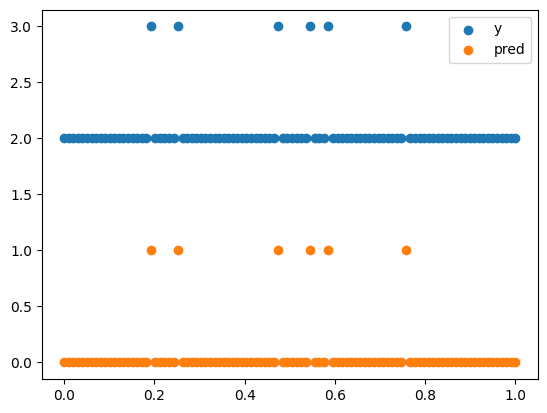

In [ ]:
model.to(device)
x, y = valid_dataset[0]
model.eval()
x = torch.unsqueeze(x, 0)
x = x.type(torch.DoubleTensor)
x = x.to(device)
pred = model(x)
pred = pred.detach().cpu().numpy()
y = y.numpy()
pred = (pred>0.5).astype(np.int16)
y = y.astype(np.int16)
plt.scatter(np.linspace(0,1, len(y)),  y + 2 )
plt.scatter(np.linspace(0, 1, len(y)), pred)
plt.legend(['y', 'pred'])
plt.show()

In [ ]:
 tp, tn, fp, fn = calculateAccuracy(model, valid_loader, device)
print(f'The percentage of cells which are troubled cells and are correctly flagged by the model : {tp*100/(tp + fn) : 0.2f}%')
print(f'The percentage of cells which are normal cells and are correctly flagged by the model : {tn * 100/(tn + fp) : 0.2f}%')

0it [00:00, ?it/s]

The percentage of cells which are troubled cells and are correctly flagged by the model :  95.35%
The percentage of cells which are normal cells and are correctly flagged by the model :  99.28%


In [ ]:
weights = torch.tensor([0.1, 0.9])
def weightedCrossEntropyLoss(x, y):
  x = torch.clamp(x, min = 1e-7, max = 1-1e-7)
  return torch.mean(-weights[1] * y * torch.log(x)  - weights[0] * (1 - y) * torch.log(1 - x))


In [ ]:
from tqdm.notebook import tqdm
model.load_state_dict(torch.load('best_model_1.pt'))
criterion =  weightedCrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
best_valid_loss = np.Inf
# Train the model
for epoch in tqdm(range(10)):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
    valid_loss = eval(model, valid_loader, criterion, device)
    if valid_loss < best_valid_loss:
      print(f'Validation loss improved from {best_valid_loss : 0.4f} to {valid_loss : 0.4f}. Saving the model')
      torch.save(model.state_dict(), 'best_model_2.pt')
      print(f'Model saved successfully')
      best_valid_loss = valid_loss

    print(f"Epoch {epoch+1}, Valid Loss: {valid_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1, Train Loss: 0.0041


0it [00:00, ?it/s]

Validation loss improved from  inf to  0.0103. Saving the model
Model saved successfully
Epoch 1, Valid Loss: 0.0103


0it [00:00, ?it/s]

Epoch 2, Train Loss: 0.0034


0it [00:00, ?it/s]

Epoch 2, Valid Loss: 0.0119


0it [00:00, ?it/s]

Epoch 3, Train Loss: 0.0025


0it [00:00, ?it/s]

Epoch 3, Valid Loss: 0.0144


0it [00:00, ?it/s]

Epoch 4, Train Loss: 0.0021


0it [00:00, ?it/s]

Epoch 4, Valid Loss: 0.0149


0it [00:00, ?it/s]

Epoch 5, Train Loss: 0.0019


0it [00:00, ?it/s]

Epoch 5, Valid Loss: 0.0155


0it [00:00, ?it/s]

Epoch 6, Train Loss: 0.0017


0it [00:00, ?it/s]

Epoch 6, Valid Loss: 0.0164


0it [00:00, ?it/s]

Epoch 7, Train Loss: 0.0015


0it [00:00, ?it/s]

Epoch 7, Valid Loss: 0.0161


0it [00:00, ?it/s]

Epoch 8, Train Loss: 0.0013


0it [00:00, ?it/s]

Epoch 8, Valid Loss: 0.0167


0it [00:00, ?it/s]

Epoch 9, Train Loss: 0.0012


0it [00:00, ?it/s]

Epoch 9, Valid Loss: 0.0194


0it [00:00, ?it/s]

Epoch 10, Train Loss: 0.0011


0it [00:00, ?it/s]

Epoch 10, Valid Loss: 0.0186


In [ ]:
model.load_state_dict(torch.load('best_model_2.pt'))

tp, tn, fp, fn = calculateAccuracy(model, valid_loader, device)

print(f'The percentage of cells which are troubled cells and are correctly flagged by the model : {tp*100/(tp + fn) : 0.2f}%')
print(f'The percentage of cells which are normal cells and are correctly flagged by the model : {tn * 100/(tn + fp) : 0.2f}%')

0it [00:00, ?it/s]

The percentage of cells which are troubled cells and are correctly flagged by the model :  98.11%
The percentage of cells which are normal cells and are correctly flagged by the model :  95.65%


In [ ]:
prec = tp*100/(tp + fp)
rec = tp * 100/(tp + fn)
print(f'Accuracy : {(tp + tn)*100/(tp + tn + fp + fn) : 0.2f}%')
print(f'Precision : {prec : 0.2f}%')
print(f'Recall : {rec : 0.2f}%')
print(f'F1 score : {2 * (rec * prec)/(rec + prec) : 0.2f}%')

Accuracy :  95.78%
Precision :  55.85%
Recall :  98.11%
F1 score :  71.18%


In [ ]:
tp, tn, fp, fn

(2598, 45198, 2054, 50)